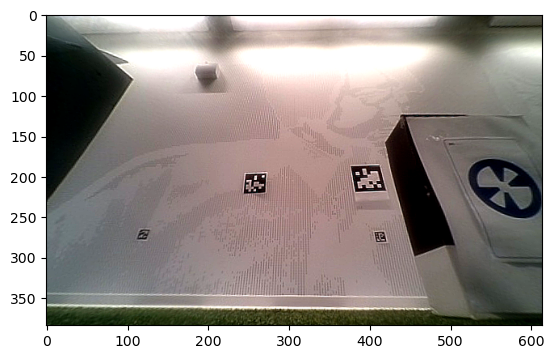

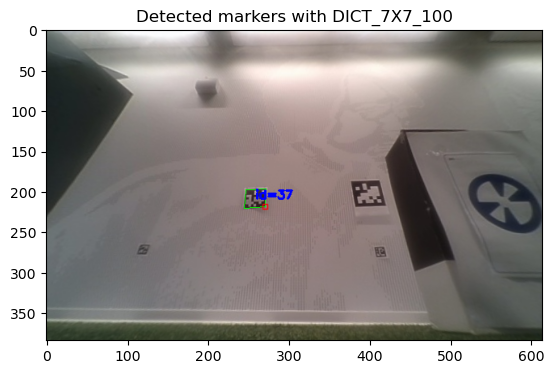

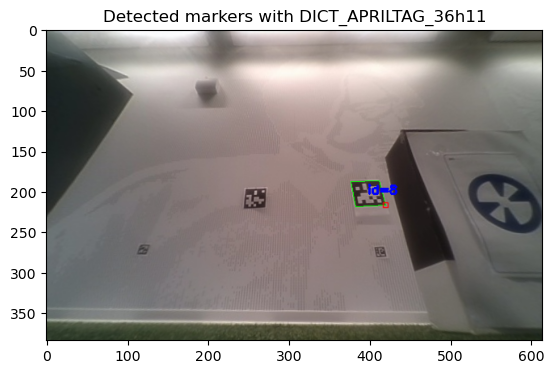

In [174]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
import numpy as np

RETDICT = {
        aruco.DICT_4X4_100: 'DICT_4X4_100',
        aruco.DICT_5X5_100: 'DICT_5X5_100',
        aruco.DICT_6X6_100: 'DICT_6X6_100',
        aruco.DICT_7X7_100: 'DICT_7X7_100',
        aruco.DICT_APRILTAG_36h11: 'DICT_APRILTAG_36h11',
        aruco.DICT_APRILTAG_25h9: 'DICT_APRILTAG_25h9',
        aruco.DICT_APRILTAG_16H5: 'DICT_APRILTAG_16H5',
        aruco.DICT_APRILTAG_36h10: 'DICT_APRILTAG_36h10',
        aruco.DICT_APRILTAG_36h11: 'DICT_APRILTAG_36h11',
        aruco.DICT_APRILTAG_36h10: 'DICT_APRILTAG_36h10',
        aruco.DICT_APRILTAG_25h9: 'DICT_APRILTAG_25h9',
    }

def detect_aruco_markers(image):
    # Convert the image to grayscale
    # UnSharpen the image
    blurred = cv2.GaussianBlur(image, (3, 3), 5)
    image = cv2.addWeighted(image, 3, blurred, -2, 0)
    
    # Sharpness filter 4x4
    sharpen_filter = np.array([
        [-1, -1, -1, -1],
        [-1, 9, 9, -1],
        [-1, 9, 9, -1],
        [-1, -1, -1, -1]
    ])
    sharpened = cv2.filter2D(image, cv2.CV_8U, sharpen_filter)
    image = cv2.addWeighted(image, 1.5, sharpened, -0.2, 0)
    plt.imshow(image[...,::-1])
    plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    retdict = RETDICT.copy()

    for key in retdict:
        aruco_dict = aruco.Dictionary_get(key)
        parameters = aruco.DetectorParameters_create()
        parameters.adaptiveThreshWinSizeStep = 1
        parameters.adaptiveThreshWinSizeMin = 3
        parameters.aprilTagMinWhiteBlackDiff = 3
        
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
        retdict[key] = (corners, ids, rejectedImgPoints)
    return retdict

# Load the image
image_path = 'random_markers_ok2.png'
image = cv2.imread(image_path)

# Detect AruCo markers
retdict = detect_aruco_markers(image)

# Get the detected markers
for key, desci in RETDICT.items():
    corners, ids, rejectedImgPoints = retdict[key]
    if ids is not None:
        viz = aruco.drawDetectedMarkers(image.copy(), corners, ids)
        plt.title(f"Detected markers with {desci}")
        plt.imshow(viz[...,::-1])
        plt.show()